# 01. Data Download and Preprocessing

Author: Minghang Li

## Download data

Donload the data from polybox and preprocess (demux etc)

Original data are stored in `<project-root>/data/raw` (please refrain from editting it!), processed data are stored in `<project-root>/data/processed`.

In [2]:
# importing all required packages & notebook extensions at the start of the notebook
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

%matplotlib inline

In [3]:
# assigning variables throughout the notebook

# location of this week's data and all the results produced by this notebook 
# - this should be a path relative to your working directory
raw_data_dir = "../data/raw"
data_dir = "../data/processed"
vis_dir  = "../results"

In [4]:
%%bash -s $raw_data_dir $data_dir $vis_dir
# Please do NOT modify this cell - here we copy the required data into
# your personal Jupyter workspace.

mkdir -p "$1" "$2" "$3"
chmod -R +rxw "$1" "$2" "$3"

In [5]:
# this will download the sequence data to <project-root>/data/raw/sequencs.qza
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/lCmJYEDg5Xz1FEA/download"


10/16 06:33:50 [NOTICE] Downloading 1 item(s)

10/16 06:33:50 [NOTICE] Allocating disk space. Use --file-allocation=none to disable it. See --file-allocation option in man page for more details.
[#b631a3 6.5GiB/6.7GiB(97%) CN:5 DL:488MiB]0m]mGiB(95%)]
10/16 06:34:23 [NOTICE] Download complete: ../data/raw/sequences.qza

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
b631a3|OK  |   310MiB/s|../data/raw/sequences.qza

Status Legend:
(OK):download completed.


In [6]:
# this will download the metadata to <project-root>/data/raw/metadata.tsv
! aria2c --max-connection-per-server="$(nproc)" \
    --allow-overwrite=true \
    -d "$raw_data_dir" \
    "https://polybox.ethz.ch/index.php/s/JrwER5E9kpgGuWd/download"


10/16 06:34:23 [NOTICE] Downloading 1 item(s)

10/16 06:34:23 [NOTICE] Download complete: ../data/raw/metadata.tsv

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
f18c08|OK  |   245KiB/s|../data/raw/metadata.tsv

Status Legend:
(OK):download completed.


In [7]:
# peek at the data
! qiime tools peek $raw_data_dir/sequences.qza

UUID:        058d7a5b-dd47-427e-b047-e5563adaefee
Type:        SampleData[PairedEndSequencesWithQuality]
Data format: SingleLanePerSamplePairedEndFastqDirFmt


In [9]:
meta = pd.read_csv(f"{raw_data_dir}/metadata.tsv", sep="\t")
meta.head()

,Sample_Name,Patient_ID,Stool_Consistency,Patient_Sex,Sample_Day,Recovery_Day,Cohort_Number
0,EG2580,P042,liquid,F,13,17.0,2
1,EG2559,P043,liquid,M,15,17.0,2
2,EG2537,P042,liquid,F,0,17.0,1
3,EG2518,P043,liquid,M,0,17.0,1
4,EG2490,P030,formed,F,0,NaN,1


Use the `demux summarize` command to get a visual summary of all our samples (Note that this is a very _lengthy_ process! Took ~500s to finish)

In [16]:
! qiime demux summarize \
    --i-data $raw_data_dir/sequences.qza \
    --o-visualization $data_dir/sequences.qzv

Saved Visualization to: ../data/processed/sequences.qzv


In [10]:
Visualization.load(f"{data_dir}/sequences.qzv")

<visualization: Visualization uuid: 2d4cbc57-79fd-4108-ada1-8dcc8cefe099>

In [11]:
# To inspect truncate & trim

qza = f"{data_dir}/sequences.qzv"
a = !unzip -o $qza 
digest = a[1].split('/')[0].replace("  inflating: ","")
fname_fwd = os.path.join(digest, "data/forward-seven-number-summaries.tsv")
fname_rev = os.path.join(digest, "data/reverse-seven-number-summaries.tsv")
fwd = pd.read_csv(fname_fwd, sep="\t", index_col=[0])
rev = pd.read_csv(fname_rev, sep="\t", index_col=[0])
!rm -r $digest

In [20]:
fwd.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
2%,32.0,27.0,31.0,34.0,34.0,36.0,34.0,36.0,36.0,35.0,...,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
9%,34.0,34.0,34.0,34.0,34.0,38.0,37.0,38.0,38.0,38.0,...,8.0,8.0,9.0,8.0,8.0,8.0,8.0,8.0,8.0,7.0
25%,34.0,34.0,34.0,34.0,34.0,38.0,38.0,38.0,38.0,38.0,...,16.0,16.0,18.0,17.0,17.0,15.0,13.0,15.0,15.0,8.0
50%,34.0,34.0,34.0,34.0,34.0,38.0,38.0,38.0,38.0,38.0,...,24.0,24.0,27.0,25.0,25.0,24.0,24.0,24.0,24.0,15.0


In [15]:
trunc_len_f = 230
trunc_len_r = 200

In [63]:
def visualize_truncation(
    df, truncate_size=200, figsize=(25, 5), color="b", save=False, save_path=None
):
    """
    Visualize truncation size for sequence quality control
    """
    # create figure
    fig, ax = plt.subplots(figsize=figsize)

    # create boxplot
    palette = {}
    for i in df.columns:
        if int(i) <= truncate_size:
            palette[i] = color
        else:
            palette[i] = "gray"

    bxpstats = df.iloc[1:].to_dict()
    # rename keys: "50%" -> "med", "25%" -> "q1", "75%" -> "q3"
    #              "9%" -> "whislo", "91%" -> "whishi"
    bxpstats = [{
            "med": v["50%"],
            "q1": v["25%"],
            "q3": v["75%"],
            "whislo": v["9%"],
            "whishi": v["91%"],
            "fliers": [v["2%"],v["98%"]]
        }
        for k, v in bxpstats.items()
    ]
    bxplot = ax.bxp(bxpstats, patch_artist=True)
    for i, patch in enumerate(bxplot['boxes']):
        patch.set_facecolor(color if i < truncate_size else "gray")

    # add vertical line for truncation size
    ax.axvline(x=truncate_size, color="r", linestyle="--")

    # add a x line for q score 30, put it at the bottom layer
    ax.axhline(y=30, color="black", linestyle="--", zorder=-233)

    # text for q score 30
    ax.text(
        0,
        30,
        "Q30",
        color="black",
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5),
    )

    # rotate x-axis labels
    ax.set_xticklabels(df.columns,rotation=90)

    # add x, y labels
    ax.set_xlabel("Sequence base position")
    ax.set_ylabel("Quality score")

    # tight layout, no space between boxes
    fig.tight_layout()

    # save figure
    if save:
        fig.savefig(save_path)


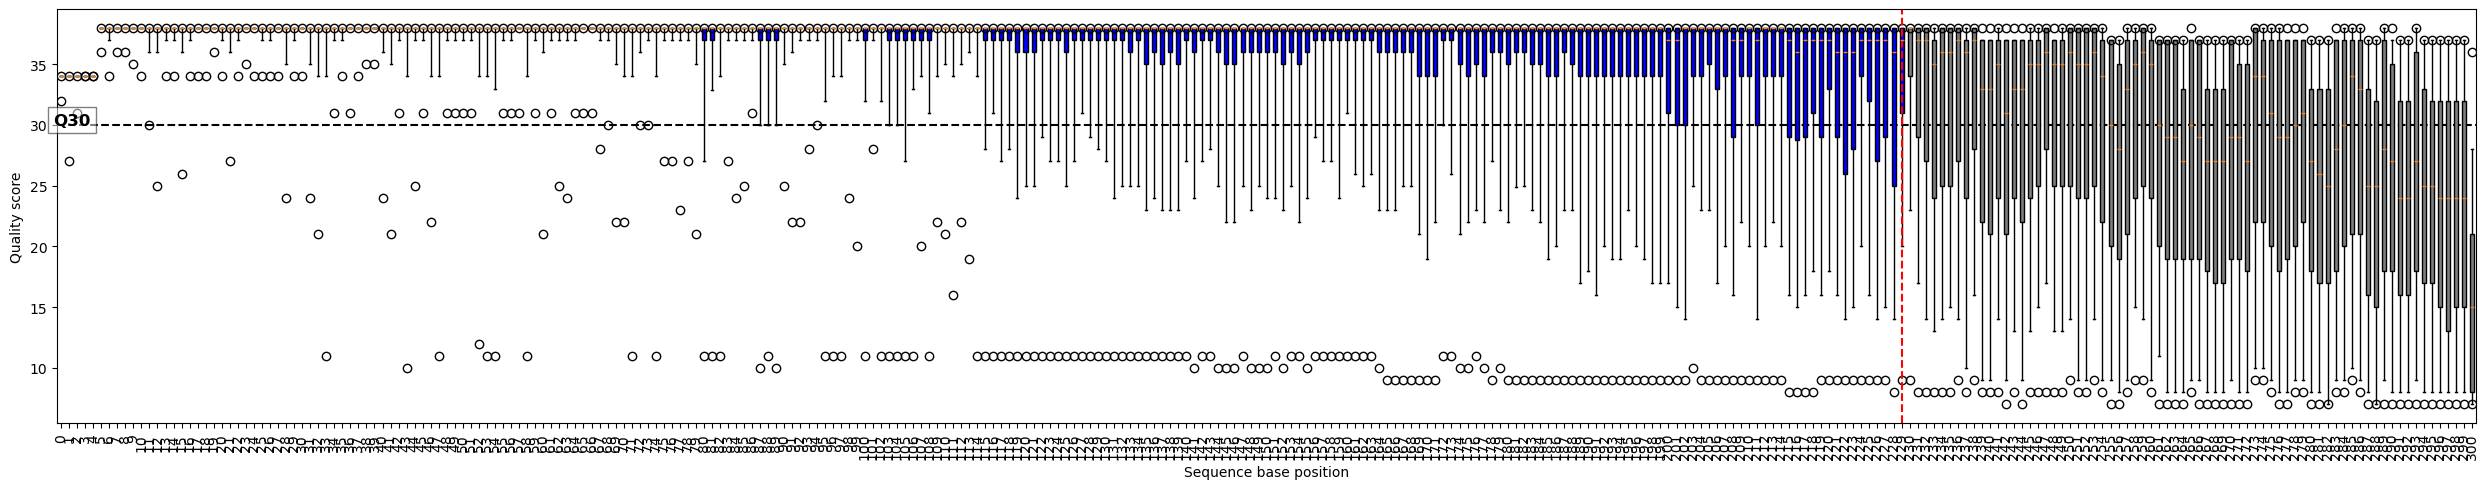

In [64]:
visualize_truncation(
    fwd, truncate_size=trunc_len_f
)

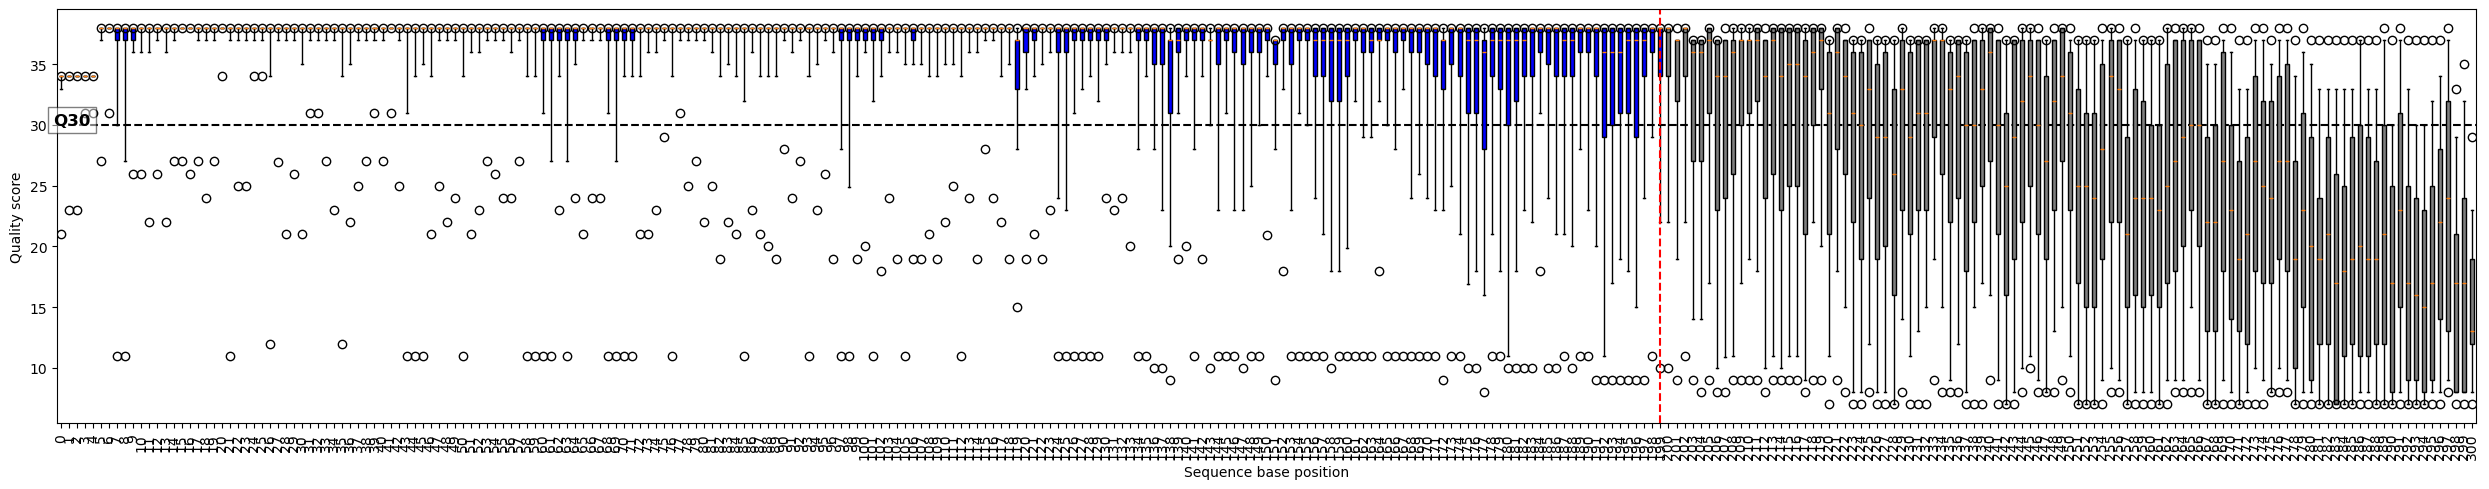

In [65]:
visualize_truncation(
    rev, truncate_size=trunc_len_r
)

## Data denoising

Use DADA2.

The parameters are not carefully selected! It's just for testing the pipeline.

In [20]:
! qiime dada2 denoise-paired \
  --i-demultiplexed-seqs $raw_data_dir/sequences.qza \
  --p-trunc-len-f 230 \
  --p-trunc-len-r 200 \
  --o-table $data_dir/table.qza \
  --o-representative-sequences $data_dir/rep-seqs.qza \
  --o-denoising-stats $data_dir/denoising-stats.qza

^C


In [21]:
! qiime feature-table summarize \
  --i-table $data_dir/table.qza \
  --o-visualization $data_dir/table.qzv \
  --m-sample-metadata-file $data_dir/sample-metadata.tsv

^C

Aborted!


In [22]:
! qiime feature-table tabulate-seqs \
  --i-data $data_dir/rep-seqs.qza \
  --o-visualization $data_dir/rep-seqs.qzv

^C

Aborted!


In [24]:
! qiime metadata tabulate \
  --m-input-file $data_dir/denoising-stats.qza \
  --o-visualization $data_dir/denoising-stats.qzv

There was an issue with loading the file ../data/processed/denoising-stats.qza as metadata:

  Metadata file path doesn't exist, or the path points to something other than a file. Please check that the path exists, has read permissions, and points to a regular file (not a directory): ../data/processed/denoising-stats.qza

  There may be more errors present in the metadata file. To get a full report, sample/feature metadata files can be validated with Keemei: https://keemei.qiime2.org

  Find details on QIIME 2 metadata requirements here: https://docs.qiime2.org/2024.5/tutorials/metadata/

